<a href="https://colab.research.google.com/github/DhavaAdePratama/trash-Image-classification/blob/main/Cats_Dogs_Snakes_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyek Klasifikasi Gambar: MACAM MACAM SAMPAH
- **Nama:** DHAVA ADE PRATAMA
- **Email:** dhavaaadepratama23@gmail.com
- **ID Dicoding:** DHAVA ADE PRATAMA

## Import Semua Packages/Library yang Digunakan

In [1]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.1/16.1 MB 43.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 31.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 37.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 41.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 26.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.7/319.7 kB 13.5 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.6
    Uninstalling protobuf-4.25.6:
      Successfully uninstalled protobuf-4.25.6
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successful

In [2]:
import pandas as pd
import os
import kagglehub
import matplotlib.pyplot as plt
from PIL import Image
import random
from shutil import copyfile
import seaborn as sns

In [3]:
# Libraries untuk pemrosesan data gambar
import cv2
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise


In [24]:
#libraries untuk modeling
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import keras
from tensorflow.keras import models, layers
from keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications import VGG16
from sklearn.metrics import classification_report
import pathlib
import tensorflowjs as tfjs
from google.colab import files
from tensorflow.keras.preprocessing import image
import matplotlib.image as mpimg

### Data Loading

In [25]:
from google.colab import files
uploaded = files.upload() # Assign the results of files.upload() to the variable 'uploaded'

for fn in uploaded.keys():
    print(f'User uploaded file "{fn}" with length {len(uploaded[fn])} bytes')

!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 71 bytes


In [6]:
!kaggle datasets download -d borhanitrash/animal-image-classification-dataset

Dataset URL: https://www.kaggle.com/datasets/borhanitrash/animal-image-classification-dataset
License(s): MIT
 70% 27.0M/38.4M [00:00<00:00, 49.1MB/s]
100% 38.4M/38.4M [00:00<00:00, 65.4MB/s]


In [7]:
from zipfile import ZipFile
file_name = "animal-image-classification-dataset.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


## Data Preparation

In [8]:
def split_data(source_dir, train_dir, val_dir, test_dir, train_size=0.70, val_size=0.20, test_size=0.10):

    if not os.path.exists(train_dir):
        os.makedirs(train_dir)
    if not os.path.exists(val_dir):
        os.makedirs(val_dir)
    if not os.path.exists(test_dir):
        os.makedirs(test_dir)

    for class_name in os.listdir(source_dir):
        source_class_dir = os.path.join(source_dir, class_name)
        if os.path.isdir(source_class_dir):
            train_class_dir = os.path.join(train_dir, class_name)
            val_class_dir = os.path.join(val_dir, class_name)
            test_class_dir = os.path.join(test_dir, class_name)

            os.makedirs(train_class_dir, exist_ok=True)
            os.makedirs(val_class_dir, exist_ok=True)
            os.makedirs(test_class_dir, exist_ok=True)

            images = [f for f in os.listdir(source_class_dir) if os.path.isfile(os.path.join(source_class_dir, f))]
            random.shuffle(images)
            num_images = len(images)
            num_train = int(num_images * train_size)
            num_val = int(num_images * val_size)

            train_images = images[:num_train]
            val_images = images[num_train:num_train + num_val]
            test_images = images[num_train + num_val:]

            for image in train_images:
                source_path = os.path.join(source_class_dir, image)
                destination_path = os.path.join(train_class_dir, image)
                copyfile(source_path, destination_path)

            for image in val_images:
                source_path = os.path.join(source_class_dir, image)
                destination_path = os.path.join(val_class_dir, image)
                copyfile(source_path, destination_path)

            for image in test_images:
                source_path = os.path.join(source_class_dir, image)
                destination_path = os.path.join(test_class_dir, image)
                copyfile(source_path, destination_path)

In [9]:
source_directory = "/content/Animals"
training_directory = "/content/train"
validation_directory = "/content/val"
testing_directory = "/content/test"

split_data(source_directory, training_directory, validation_directory, testing_directory)

In [10]:
train_dir = "train"
test_dir = "test"
val_dir = "val"

print("Training set:", os.listdir(train_dir))
print("Testing set:", os.listdir(test_dir))
print("Validation set:", os.listdir(val_dir))

Training set: ['cats', 'snakes', 'dogs']
Testing set: ['cats', 'snakes', 'dogs']
Validation set: ['cats', 'snakes', 'dogs']


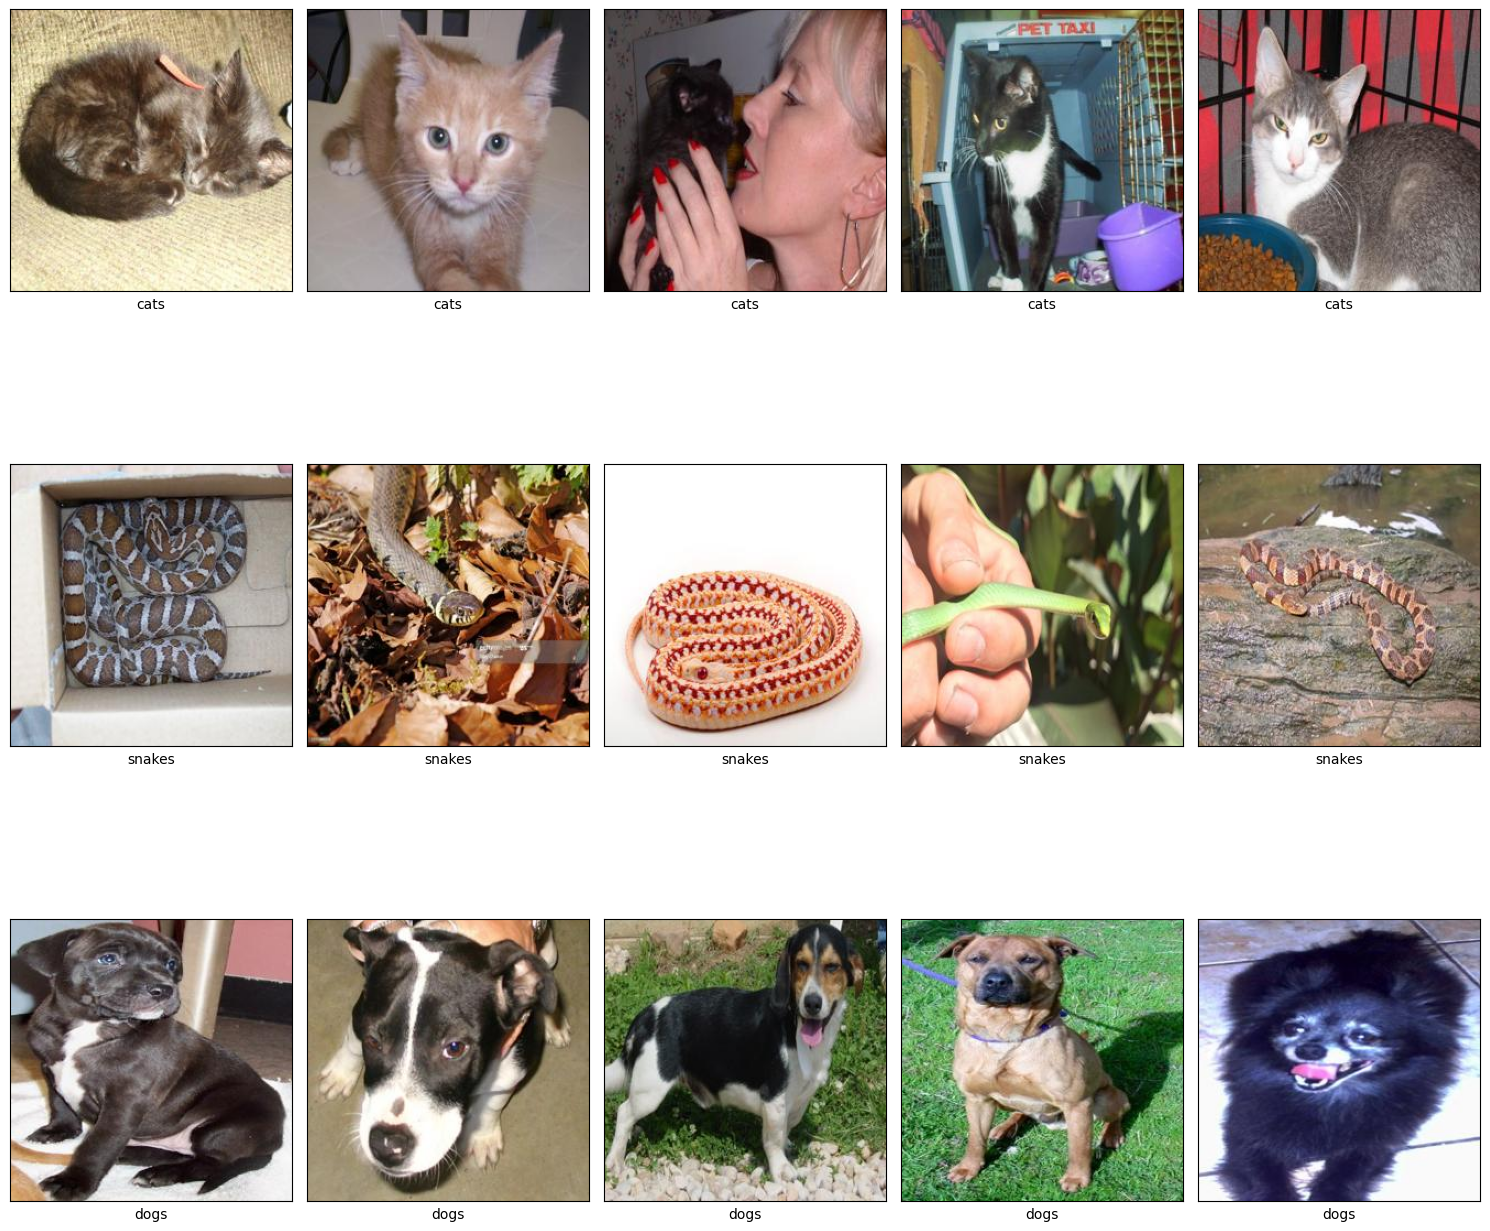

In [11]:
#Checking Dataset
lung_image = {}

# Tentukan path sumber train
path = "train"
# path_sub = os.path.join(path, "Train") # Remove or comment out this line as "Train" directory doesn't exist
for i in os.listdir(path): # Use path directly to iterate through the classes
    lung_image[i] = os.listdir(os.path.join(path, i))

# Menampilkan secara acak 5 gambar di bawah setiap dari 2 kelas dari data.
# Anda akan melihat gambar yang berbeda setiap kali kode ini dijalankan.
path_sub = "Animals"

# Menampilkan secara acak 5 gambar di bawah setiap kelas dari data latih
fig, axs = plt.subplots(len(lung_image.keys()), 5, figsize=(15, 15))

import numpy as np # Import numpy for np.random.choice

for i, class_name in enumerate(os.listdir(path_sub)): # Update loop to use 'path' instead of 'path_sub'
    images = np.random.choice(lung_image[class_name], 5, replace=False)

    for j, image_name in enumerate(images):
        img_path = os.path.join(path_sub, class_name, image_name)# Update path_sub to 'path'
        img = Image.open(img_path).convert('RGB')
        axs[i, j].imshow(img)
        axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])


fig.tight_layout()

### Data Preprocessing

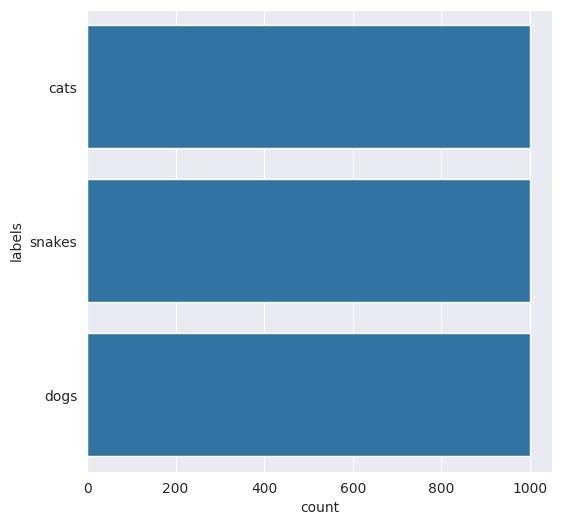

In [12]:
#Melihat distribusi gambar setiap kelasnya
lung_path = "Animals"

file_name = []
labels = []
full_path = []

# Dapatkan nama file gambar, path file, dan label satu per satu dengan looping, dan simpan sebagai dataframe
for path, subdirs, files in os.walk(lung_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_train = pd.DataFrame({"path":full_path, 'file_name':file_name, "labels":labels})

# Plot distribusi gambar di setiap kelas
Label = distribution_train['labels']
plt.figure(figsize = (6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

data pada setiap kelasnya setara


In [13]:
# IMAGE DATA GENERATOR
datagen = ImageDataGenerator(
                              rescale=1/255.,
                              rotation_range=20,
                              width_shift_range=0.2,
                              height_shift_range=0.2,
                              shear_range=0.2,
                              zoom_range=0.2,
                              horizontal_flip=True,
                              fill_mode='nearest')

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(train_dir,
                                              batch_size=32,
                                              target_size=(224,224),
                                              class_mode='categorical',
                                              subset='training')


validation_generator = val_test_datagen.flow_from_directory(val_dir,
                                                            batch_size=1,
                                                            target_size=(224,224),
                                                            class_mode='categorical')


test_generator = val_test_datagen.flow_from_directory(test_dir,
                                                      batch_size=1,
                                                      target_size=(224,224),
                                                      class_mode='categorical',
                                                      shuffle=False)

Found 2100 images belonging to 3 classes.
Found 600 images belonging to 3 classes.
Found 300 images belonging to 3 classes.


#### Split Dataset

In [14]:
split_data

<function __main__.split_data(source_dir, train_dir, val_dir, test_dir, train_size=0.7, val_size=0.2, test_size=0.1)>

## Modelling

In [15]:
# Transfer Learning
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [16]:
# Define CNN Model
model = Sequential([
       base_model,
       # First convolutional block
       Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(224, 224, 3)),
       MaxPooling2D((2, 2)),
       # Flatten the output of the last Conv2D layer
       Flatten(),
       # Fully connected layers
       Dropout(0.5),
       Dense(128, activation='relu'),
       Dropout(0.3),
       Dense(64, activation='relu'),
       Dropout(0.2),
       Dense(3, activation='softmax')
    ])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
checkpoint= ModelCheckpoint('model.h5',save_best_only=True, monitor= 'val_loss', mode = 'min' )
# Train the model
Trainig_model= model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    callbacks=[early_stopping, reduce_lr,checkpoint]
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 602ms/step - accuracy: 0.3876 - loss: 1.1485

66/66 ━━━━━━━━━━━━━━━━━━━━ 66s 720ms/step - accuracy: 0.3890 - loss: 1.1462 - val_accuracy: 0.8067 - val_loss: 0.5783 - learning_rate: 5.0000e-04
Epoch 2/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step - accuracy: 0.6760 - loss: 0.6803

66/66 ━━━━━━━━━━━━━━━━━━━━ 50s 492ms/step - accuracy: 0.6764 - loss: 0.6793 - val_accuracy: 0.8783 - val_loss: 0.3761 - learning_rate: 5.0000e-04
Epoch 3/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step - accuracy: 0.7781 - loss: 0.5121

66/66 ━━━━━━━━━━━━━━━━━━━━ 35s 531ms/step - accuracy: 0.7783 - loss: 0.5117 - val_accuracy: 0.8583 - val_loss: 0.3104 - learning_rate: 5.0000e-04
Epoch 4/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step - accuracy: 0.8340 - loss: 0.4227

66/66 ━━━━━━━━━━━━━━━━━━━━ 40s 602ms/step - accuracy: 0.8340 - loss: 0.4224 - val_accuracy: 0.9033 - val_loss: 0.2190 - learning_rate: 5.0000e-04
Epoch 5/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step - accuracy: 0.8467 - loss: 0.3702

66/66 ━━━━━━━━━━━━━━━━━━━━ 37s 565ms/step - accuracy: 0.8468 - loss: 0.3703 - val_accuracy: 0.9133 - val_loss: 0.1998 - learning_rate: 5.0000e-04
Epoch 6/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 40s 604ms/step - accuracy: 0.8835 - loss: 0.3183 - val_accuracy: 0.9083 - val_loss: 0.2274 - learning_rate: 5.0000e-04
Epoch 7/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 36s 544ms/step - accuracy: 0.8916 - loss: 0.3192 - val_accuracy: 0.8783 - val_loss: 0.2788 - learning_rate: 5.0000e-04
Epoch 8/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step - accuracy: 0.8710 - loss: 0.3293

66/66 ━━━━━━━━━━━━━━━━━━━━ 33s 498ms/step - accuracy: 0.8711 - loss: 0.3290 - val_accuracy: 0.9367 - val_loss: 0.1712 - learning_rate: 5.0000e-04
Epoch 9/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step - accuracy: 0.8875 - loss: 0.2933

66/66 ━━━━━━━━━━━━━━━━━━━━ 33s 506ms/step - accuracy: 0.8876 - loss: 0.2932 - val_accuracy: 0.9367 - val_loss: 0.1649 - learning_rate: 5.0000e-04
Epoch 10/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 41s 499ms/step - accuracy: 0.8877 - loss: 0.2906 - val_accuracy: 0.9100 - val_loss: 0.1951 - learning_rate: 5.0000e-04
Epoch 11/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step - accuracy: 0.8916 - loss: 0.2696

66/66 ━━━━━━━━━━━━━━━━━━━━ 33s 506ms/step - accuracy: 0.8917 - loss: 0.2695 - val_accuracy: 0.9433 - val_loss: 0.1601 - learning_rate: 5.0000e-04
Epoch 12/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 37s 569ms/step - accuracy: 0.8993 - loss: 0.2679 - val_accuracy: 0.9167 - val_loss: 0.2217 - learning_rate: 5.0000e-04
Epoch 13/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 38s 570ms/step - accuracy: 0.8973 - loss: 0.2670 - val_accuracy: 0.9167 - val_loss: 0.2184 - learning_rate: 5.0000e-04
Epoch 14/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 33s 495ms/step - accuracy: 0.9070 - loss: 0.2305 - val_accuracy: 0.9283 - val_loss: 0.1681 - learning_rate: 5.0000e-04
Epoch 15/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step - accuracy: 0.9249 - loss: 0.2091

66/66 ━━━━━━━━━━━━━━━━━━━━ 33s 502ms/step - accuracy: 0.9248 - loss: 0.2093 - val_accuracy: 0.9350 - val_loss: 0.1545 - learning_rate: 5.0000e-04
Epoch 16/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 34s 506ms/step - accuracy: 0.9241 - loss: 0.2099 - val_accuracy: 0.9217 - val_loss: 0.1794 - learning_rate: 5.0000e-04
Epoch 17/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 33s 504ms/step - accuracy: 0.8981 - loss: 0.2744 - val_accuracy: 0.9383 - val_loss: 0.1606 - learning_rate: 5.0000e-04
Epoch 18/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 33s 497ms/step - accuracy: 0.9205 - loss: 0.2199 - val_accuracy: 0.9350 - val_loss: 0.1650 - learning_rate: 5.0000e-04
Epoch 19/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 32s 490ms/step - accuracy: 0.9082 - loss: 0.2407 - val_accuracy: 0.9317 - val_loss: 0.1597 - learning_rate: 5.0000e-04
Epoch 20/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 41s 491ms/step - accuracy: 0.9200 - loss: 0.2149 - val_accuracy: 0.9150 - val_loss: 0.2053 - learning_rate: 5.0000e-04


## Evaluasi dan Visualisasi

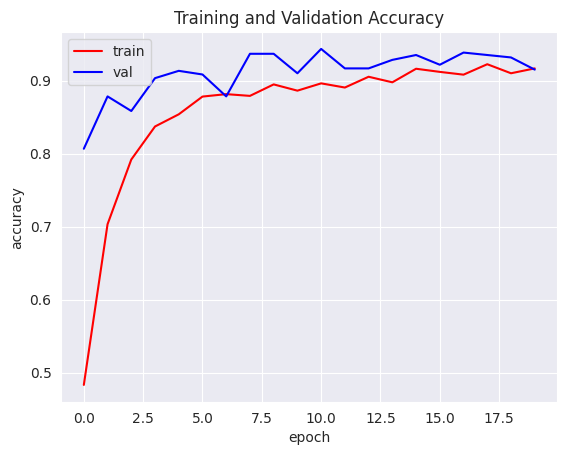

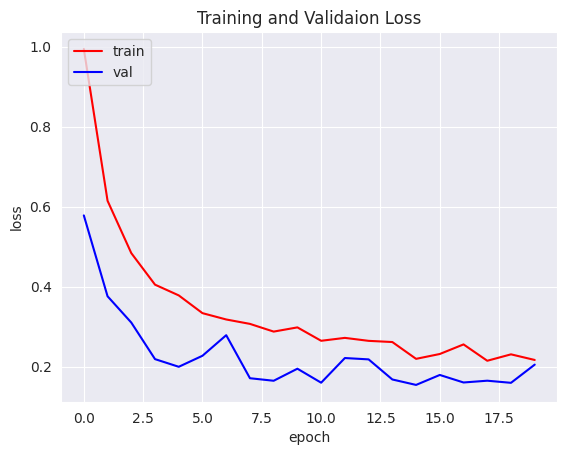

In [17]:
acc = Trainig_model.history['accuracy']
val_acc = Trainig_model.history['val_accuracy']
loss = Trainig_model.history['loss']
val_loss = Trainig_model.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validaion Loss')
plt.show()

In [18]:
# Evaluasi model menggunakan data pengujian
evaluation = model.evaluate(
    test_generator,
    steps=test_generator.samples // test_generator.batch_size
)

# Menampilkan hasil evaluasi
print("Loss:", evaluation[0])
print("Accuracy:", evaluation[1])

300/300 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9294 - loss: 0.2280
Loss: 0.15850621461868286
Accuracy: 0.9399999976158142


In [19]:
#classification report
predictions = model.predict(test_generator)

y_pred = np.argmax(predictions, axis=1)

y_true = test_generator.classes

target_names = ['cats', 'dogs', 'snakes']

report = classification_report(y_true, y_pred, target_names=target_names, digits=4)
print(report)

300/300 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step
              precision    recall  f1-score   support

        cats     0.9038    0.9400    0.9216       100
        dogs     0.9570    0.8900    0.9223       100
      snakes     0.9612    0.9900    0.9754       100

    accuracy                         0.9400       300
   macro avg     0.9407    0.9400    0.9397       300
weighted avg     0.9407    0.9400    0.9397       300



## Konversi Model

In [20]:
#Format Saved Model
save_path = 'mymodel/'
tf.saved_model.save(model, save_path)

In [21]:
#konversi format saved model ke TF Lite
converter = tf.lite.TFLiteConverter.from_saved_model(save_path)
tflite_model = converter.convert()

tflite_model_file = pathlib.Path('Animals.tflite')
tflite_model_file.write_bytes(tflite_model)

26576

In [22]:
#Konversi format saved_mode ke TFJS
tfjs.converters.save_keras_model(model, 'tfjs_model')

failed to lookup keras version from the file,
    this is likely a weight only file


## Inference (Optional)

Saving 2_0002.jpg to 2_0002.jpg


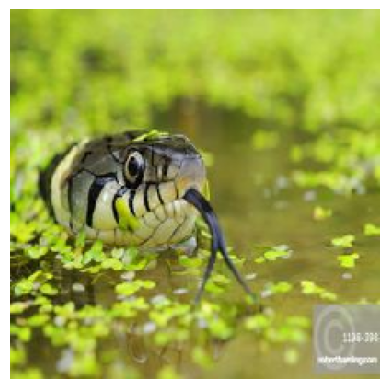

Filename: 2_0002.jpg
Prediction: snakes


In [35]:
uploaded = files.upload()

# Load the SavedModel
model = tf.saved_model.load("mymodel")

# Get the prediction function from the loaded model
infer = model.signatures["serving_default"]

for fn in uploaded.keys():
    path = fn
    img = image.load_img(path, target_size=(224, 224))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    # Preprocess the image
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)  # Add batch dimension
    x = x / 255.0  # Normalize if required by the model

    # Convert the input to a TensorFlow tensor
    x = tf.convert_to_tensor(x, dtype=tf.float32)

    # Predict using the infer function
    predictions = infer(x)

    # Extract the prediction values
    predictions = predictions['output_0'].numpy()  # Replace 'dense_2' with the actual output layer name

    # Interpret results (modify based on your model output)
    class_index = np.argmax(predictions, axis=1)[0]
    class_labels = ['cats', 'dogs', 'snakes']  # Sesuaikan dengan label model Anda

    print(f"Filename: {fn}")
    print(f"Prediction: {class_labels[class_index]}")